## Importing Modules

In [1]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image
from more_itertools import chunked
from tqdm import tqdm

sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Configuration Setup

In [2]:
comp_path = Path('/kaggle/input/stable-diffusion-image-to-prompts/')
sample_submission = pd.read_csv(comp_path / 'sample_submission.csv', index_col='imgId_eId')

In [3]:
# load sentence transformer model
st_model = SentenceTransformer('/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2')

### Stable Diffusion process with vit-gpt2-image-captioning pretrained weights

In [4]:
# setup captioning model
# reference: https://huggingface.co/nlpconnect/vit-gpt2-image-captioning
model_dir = "/kaggle/input/vitgpt2"

model = VisionEncoderDecoderModel.from_pretrained(model_dir)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 10
num_beams = 3
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

Some weights of the model checkpoint at /kaggle/input/vitgpt2 were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.5.crossattention.bias', 'decoder.transformer.h.2.attn.bias', 'decoder.transformer.h.11.crossattention.bias', 'decoder.transformer.h.9.attn.bias', 'decoder.transformer.h.1.attn.masked_bias', 'decoder.transformer.h.1.crossattention.masked_bias', 'decoder.transformer.h.8.attn.masked_bias', 'decoder.transformer.h.0.attn.bias', 'decoder.transformer.h.4.attn.masked_bias', 'decoder.transformer.h.3.crossattention.masked_bias', 'decoder.transformer.h.10.attn.masked_bias', 'decoder.transformer.h.7.crossattention.masked_bias', 'decoder.transformer.h.5.attn.masked_bias', 'decoder.transformer.h.2.attn.masked_bias', 'decoder.transformer.h.10.attn.bias', 'decoder.transformer.h.7.attn.masked_bias', 'decoder.transformer.h.9.attn.masked_bias', 'decoder.transformer.h.6.crossattention.masked_bias', 'decoder.transformer.h.6.crossattention.bias', 'decoder.transform

In [5]:
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

In [6]:
def load_image_paths(image_dir, image_ids):
    image_path_list = []
    image_set = set()
    for image_id in image_ids:
        if image_id in image_set:
            continue
        image_set.add(image_id)
        image_path_list.append(f"{image_dir}/{image_id}.png")
    return image_path_list

In [7]:
image_ids = [val.split("_")[0] for val in sample_submission.index]
image_dir = "/kaggle/input/stable-diffusion-image-to-prompts/images/"
image_path_list = load_image_paths(image_dir, image_ids)

## Predicting on Example Data

In [8]:
example_prompt = predict_step(image_path_list[:1])[0]
print(example_prompt)

an old rusty fire hydrant in the middle


In [9]:
# example embedding
print(st_model.encode(example_prompt).flatten()[:10])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[-0.09332216  0.10216729 -0.02233811 -0.01014308  0.09350655 -0.01802969
  0.01196276  0.04338516 -0.00141717 -0.07623405]


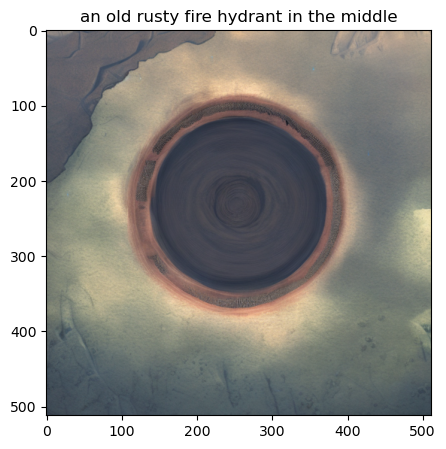

In [10]:
# predicted prompt and image
image = cv2.imread(image_path_list[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(example_prompt, fontsize=12)
plt.show()

## Predicting on Test Data

In [11]:
batch_size = 16
preds = [
    st_model.encode(predict_step(chunk_paths)).flatten()
    for chunk_paths in tqdm(chunked(image_path_list, batch_size))
]

flatten_pred = [ 
    pred
    for chunk_pred in preds
    for pred in chunk_pred
]

0it [00:00, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1it [00:00,  1.87it/s]


In [12]:
sample_submission["val"] = flatten_pred
sample_submission.to_csv("./submission.csv")